## Closing budgets for heat, salt and biogeochemical tracers

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gsw
import budgetcalcs as bc

In [2]:
rootdir = '/archive/gam/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/history/'
filename = '08500101.ocean_month.nc'
ds = xr.open_dataset(rootdir+filename)

# Correct MOM6 tendencies to account for mass in cell
# i.e. convert from [mol kg^-1 m s^-1] to [mol m^-2 s^-1]
rho0=1035.0
ds['o2h_tendency'] *= rho0
ds['o2h_tendency_vert_remap'] *= rho0
ds['o2_advection_xy'] *= rho0
ds['o2_dfxy_cont_tendency'] *= rho0
ds['o2_vdiffuse_impl'] *= rho0
# Remove bottom boundary flux from jo2_plus_btm (already included in o2_vdiffuse_impl)
jo2_btm = xr.zeros_like(ds.jo2_plus_btm)
jo2_btm.loc[dict(zl=ds.zl.max())]=ds.o2_btf
jo2 = ds.jo2_plus_btm - jo2_btm
jo2.name = 'jo2'
ds = xr.merge([ds,jo2])

# Take some subsamples of the output
prof = ds.sel(xh=-150,yh=20,method='nearest').squeeze()
slic = ds.sel(zl=100,method='nearest').squeeze()
ksum = ds.sum(dim='zl').squeeze()

/nbhome/gam/miniconda/envs/mom6/lib/python3.7/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)


***
### Oxygen
#### Vertical sum

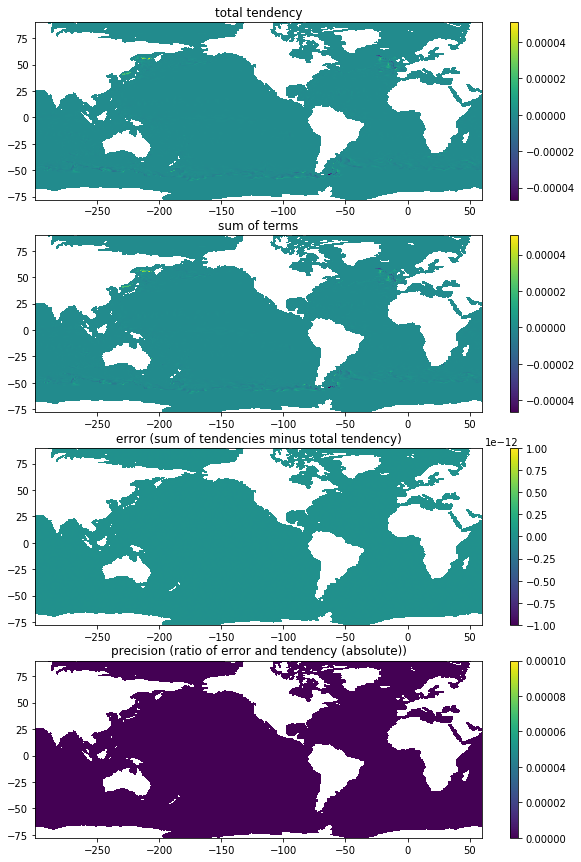

In [4]:
# Oxygen
o2_terms = ['o2_advection_xy','o2h_tendency_vert_remap','o2_dfxy_cont_tendency','o2_vdiffuse_impl','jo2']
tend = 'o2h_tendency'
tend_sum, error = bc.calc_budget(slic,o2_terms,tend,omit=[],errors=[-1E-12,1E-12])

#### Single profile

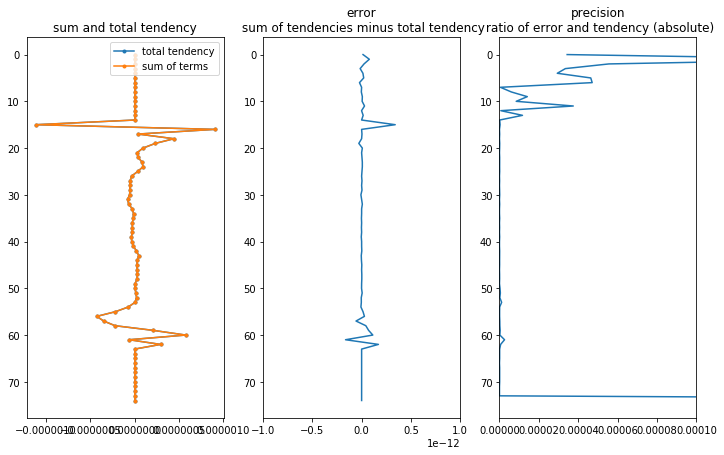

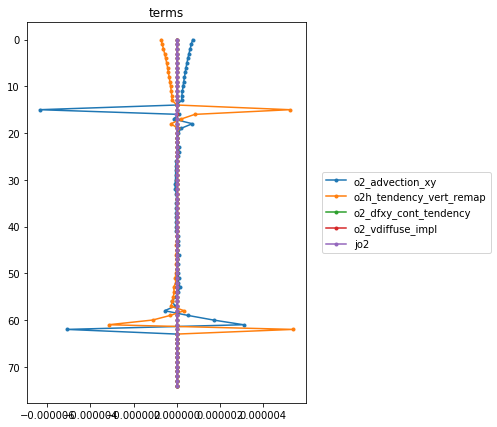

In [80]:
tend_sum, error = calc_budget(prof,o2_terms,tend,omit=[],errors=[-1E-12,1E-12])
plot_budgetterms(prof,o2_terms)

#### Material derivative balanced by diffusion and source/sink terms

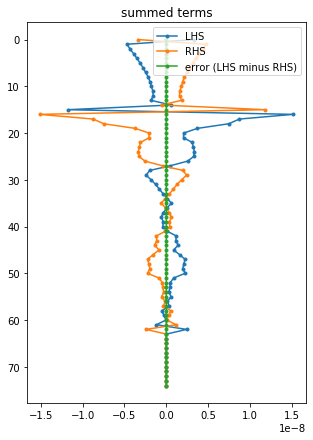

In [32]:
termsLHS = ['o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap']
signsLHS = [-1,1,1]
termsRHS = ['o2_dfxy_cont_tendency','o2_vdiffuse_impl','jo2']
signsRHS = [1,1,1]
plot_summedterms(prof,termsLHS,signsLHS,termsRHS,signsRHS)

***
### Heat
#### Vertical sum

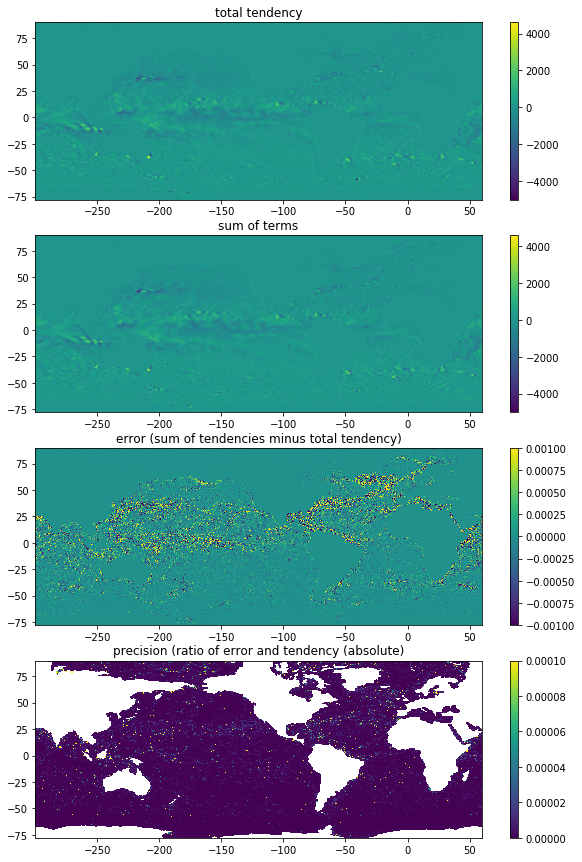

In [81]:
# Heat
heat_terms = ['T_advection_xy','Th_tendency_vert_remap','boundary_forcing_heat_tendency','internal_heat_tend_3d','opottempdiff','opottemppmdiff','frazil_heat_tendency']
tend = 'opottemptend'
tend_sum, error = calc_budget(ksum,heat_terms,tend,errors=[-1E-3,1E-3])

#### Single profile

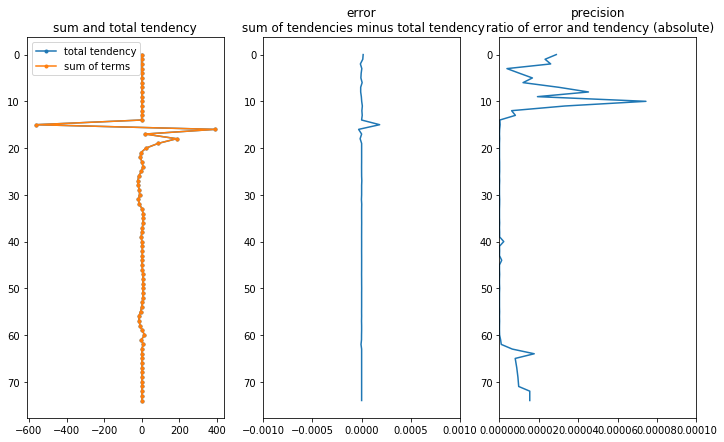

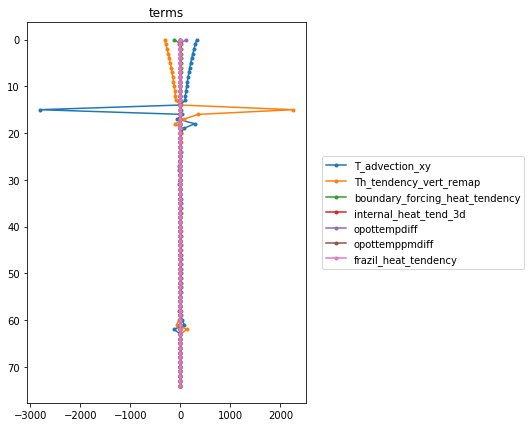

In [82]:
tend_sum, error = calc_budget(prof,heat_terms,tend,omit=[],errors=[-1E-3,1E-3])
plot_budgetterms(prof,heat_terms)

#### Material derivative balanced by diffusion and source/sink terms

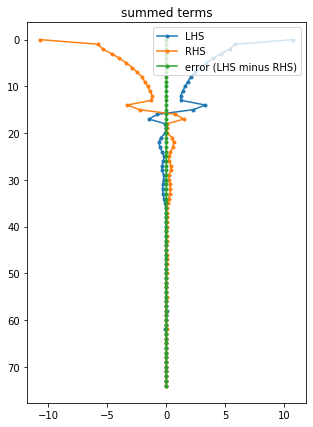

In [29]:
termsLHS = ['opottemptend','T_advection_xy','Th_tendency_vert_remap']
signsLHS = [-1,1,1]
termsRHS = ['boundary_forcing_heat_tendency','internal_heat_tend_3d','opottempdiff','opottemppmdiff','frazil_heat_tendency']
signsRHS = [1,1,1,1,1]
plot_summedterms(prof,termsLHS,termsRHS)

***
### Salt
#### Vertical sum

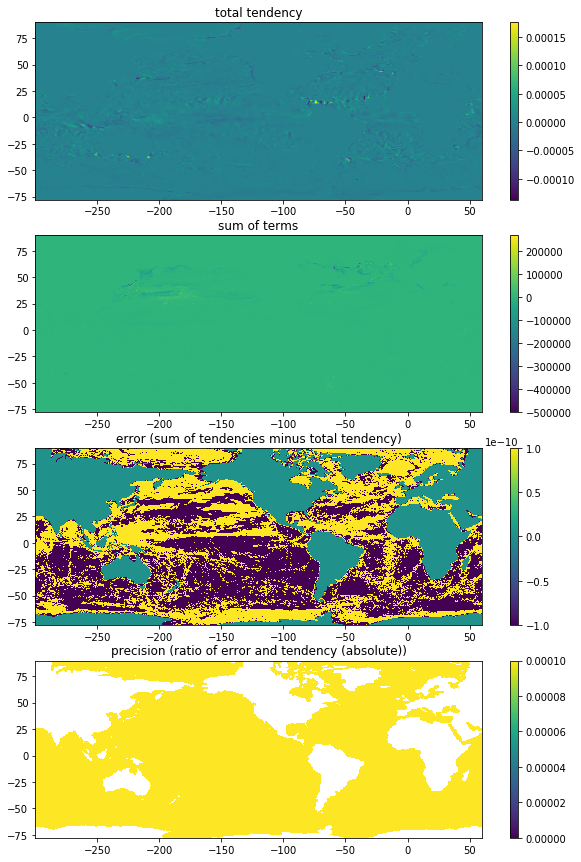

In [3]:
# Salt
salt_terms = ['S_advection_xy','Sh_tendency_vert_remap','boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']
tend = 'osalttend'
tend_sum, error = bc.calc_budget(ksum,salt_terms,tend,omit=[],errors=[-1E-10,1E-10])

#### Single profile

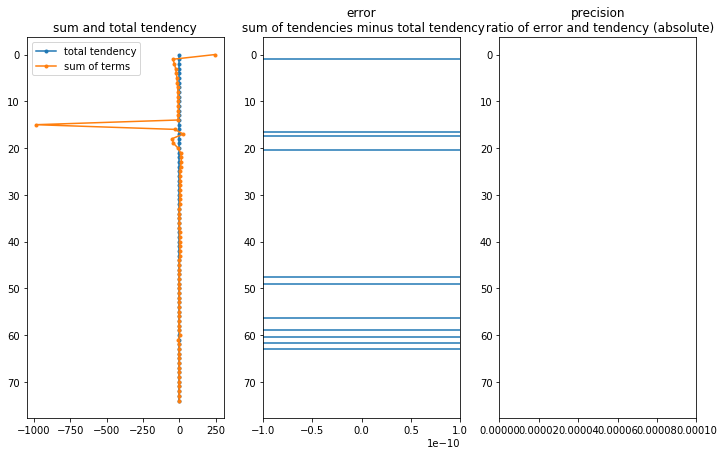

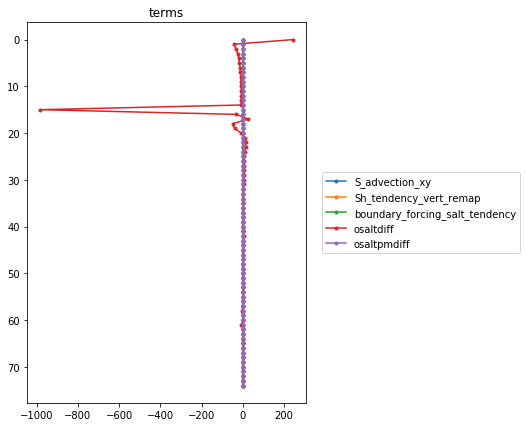

In [4]:
tend_sum, error = bc.calc_budget(prof,salt_terms,tend,omit=[],errors=[-1E-10,1E-10])
bc.plot_budgetterms(prof,salt_terms,omit=[])

In [ ]:
termsLHS = ['osalttend','S_advection_xy','Sh_tendency_vert_remap']
signsLHS = [-1,1,1]
termsRHS = ['boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']
signsRHS = [1,1,1]
bc.calc_materialderivative(prof,termsLHS,signsLHS,termsRHS,signsRHS,plot=True)

In [12]:
tend

'osalttend'